In [16]:
# Import relevant packages for analysis below.
%matplotlib inline
import stan as ps
import patsy as pt
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

import nest_asyncio
nest_asyncio.apply()

# Script functions

# Transformation function from Smithson and Verkuilen (2006) so the dependent variable values are > 0 and < 1
def beta_transform(x):
    n = len(x)
    y = (x * (n - 1) + .5)/n
    return(y)

In [2]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

In [3]:
url = "https://raw.githubusercontent.com/ebrlab/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/master/wip/Data/Atir%20Rosenzweig%20Dunning%202015.csv"

#Read in csv of the data from Atir, S., Rosenzweig, E., & Dunning, D. (2015).
df = pd.read_csv(url)

# Outpur head of dataframe
df.head(3)

,id,order_of_tasks,self_perceived_knowledge,overclaiming_proportion,accuracy,FINRA_score
0,1,1,5.5,0.444444,0.250000,4
1,7,1,4.5,0.555556,0.194444,4
2,10,1,3.5,0.166667,0.347222,5


In [54]:
beta_reg = '''

data {
  int<lower=1> N;                      // Number of observations
  int<lower=1> K;                      // # of predictors
  vector<lower=0,upper=1>[N] y;        // Dependent variable
  matrix[N,K] X;                       // Design matrix
}

parameters {
  vector[K] theta;                     // reg coefficients
  real<lower=0> phi;                   // dispersion parameter
}

transformed parameters{
// model calculations  
  vector[K] beta;
  vector[N] A;                         
  vector[N] B;
  vector[N] LP;                        
  vector[N] mu;  
  
beta = theta * 5;
LP = X * beta;
  

mu = inv_logit(LP);   
A = mu * phi;
B = (1.0 - mu) * phi;
  
  
}

model{ 

  // priors
  theta ~ normal(0, 1);   
  phi ~ cauchy(0, 5);                  // different options for phi  
  
  // likelihood
  y ~ beta(A, B);
} 
generated quantities {
  real yrep[N];
  yrep = beta_rng(A,B);
}
'''

In [55]:
#Generate design matrix for the regression analysis for use in the stan model above
x = np.asarray(pt.dmatrix(' ~ self_perceived_knowledge + accuracy', data = df))

In [56]:
data = data = {
    'N': len(df),
    'K': x.shape[1],
    'X': x,
    'y': beta_transform(df['overclaiming_proportion'].values)
    }

In [57]:
sm = ps.build(beta_reg, data = data)

Building...



Building: 51.0s, done.

In [58]:
fit = sm.sample(num_chains = 4, num_samples = 1000)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   3% (203/8000)
Sampling:   5% (402/8000)
Sampling:   8% (601/8000)
Sampling:   9% (700/8000)
Sampling:  11% (900/8000)
Sampling:  15% (1200/8000)
Sampling:  18% (1400/8000)
Sampling:  20% (1600/8000)
Sampling:  24% (1900/8000)
Sampling:  28% (2200/8000)
Sampling:  31% (2500/8000)
Sampling:  52% (4200/8000)
Sampling:  69% (5500/8000)
Sampling:  84% (6700/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000163 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.63 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: First shape parameter[1] is 0, but must be positive finite! (in '/tmp/httpstan_wkhzpsgo/model_c4qxhfun.stan', line 3

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: First shape parameter[1] is 0, but must be positive finite! (in '/tmp/httpstan_wkhzpsgo/model_c4qxhfun.stan', line 39, column 2 to column 17)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: beta_lpdf: Second shape parameter[1] is 0, but must be positive finite! (in '/tmp/httpstan_wkhzpsgo/model_c4qxhfun.stan', line 39, column 2 to column 17)
  Gradient evaluation took 0.000156 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.56 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis propo

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Second shape parameter[1] is 0, but must be positive finite! (in '/tmp/httpstan_wkhzpsgo/model_c4qxhfun.stan', line 39, column 2 to column 17)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Second shape parameter[1] is 0, but must be positive finite! (in '/tmp/httpstan_wkhzpsgo/model_

In [64]:
fit_df = fit.to_frame()
az.summary(fit, var_names = ['beta', 'phi'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-2.384,0.233,-2.820,-1.947,0.006,0.004,1705.0,2115.0,1.0
beta[1],0.591,0.049,0.498,0.682,0.001,0.001,1769.0,2106.0,1.0
beta[2],-4.184,0.269,-4.682,-3.685,0.005,0.004,2431.0,2567.0,1.0
phi,8.226,0.822,6.687,9.747,0.017,0.012,2438.0,2284.0,1.0


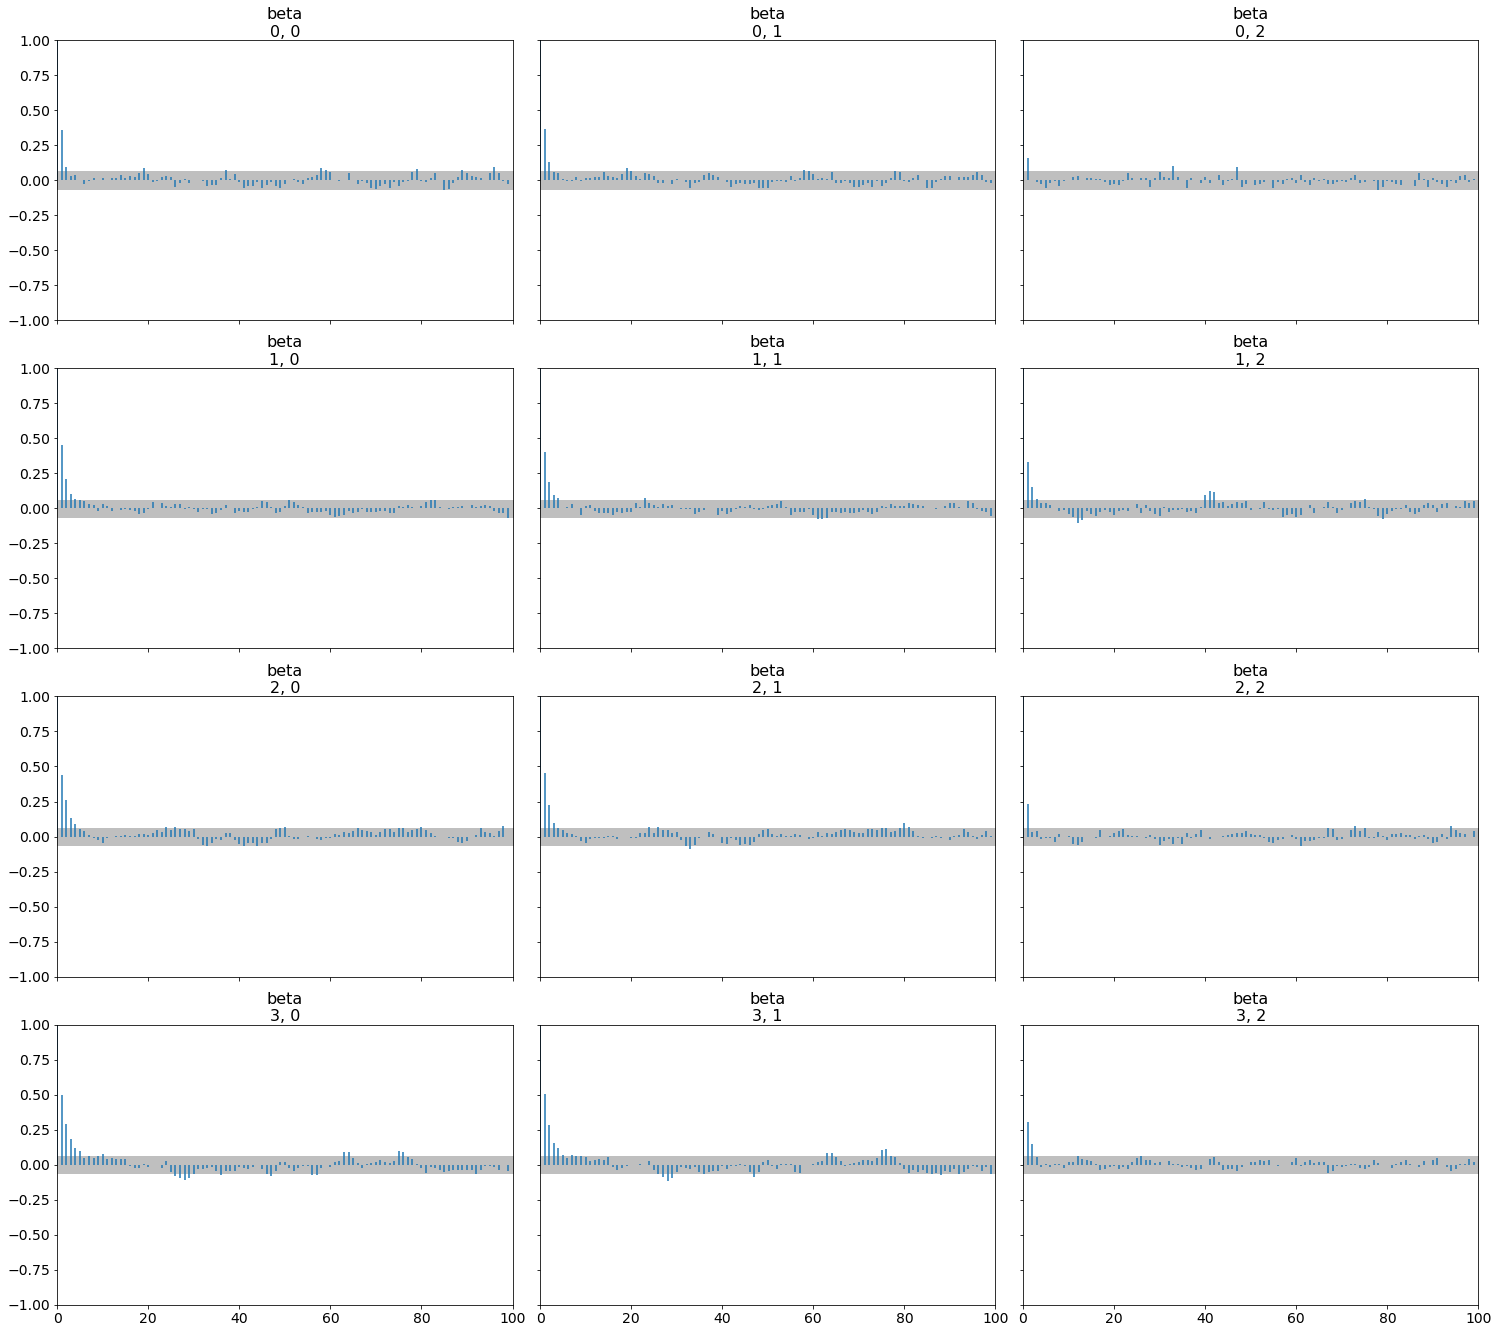

In [26]:
az.plot_autocorr(fit,var_names=("beta"));

Autocorrelation plots show no pathologies with scores quickly decreasing to around 0

In [59]:
# Convert pystan fit object to IO for Arviz functions.
idata = az.from_pystan(posterior=fit,posterior_model = sm, posterior_predictive=['yrep'],observed_data= 'y')

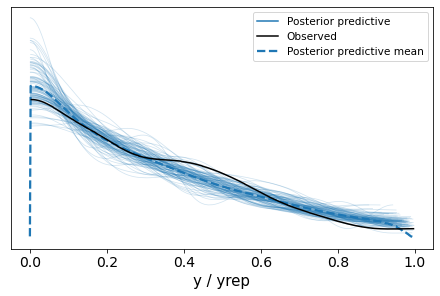

In [60]:
# Plot posterior simulated data sets for posterior predictive check
az.plot_ppc(idata, data_pairs = {"y" : "yrep"}, num_pp_samples= 100);

As the posterior predictive check show the Beta likelihood model fit the data (overclaiming proportion scores) more effectively compared too the normal likelihood model fittedto the same data (see, the multiple regression notebook example).

# References

Smithson, M., & Verkuilen, J. (2006). A better lemon squeezer? Maximum-likelihood regression with beta-distributed dependent variables. Psychological methods, 11(1), 54.